In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tstools import TimeSeriesStationarizer


In [2]:
train_df = pd.read_csv('train_imputed.csv')
test_df = pd.read_csv('/Users/minqi/Documents/Kaggle/kaggle_hull_tactic_2025/train.csv')

### Simple linear regression

In [3]:
target = 'forward_returns'
non_dummy_features = [col for col in train_df.columns if col[0] in ['E','I','M','P','S','V']]
dummy_features = [col for col in train_df.columns if 'D' in col]
others = train_df.columns.difference(non_dummy_features + dummy_features + [target])

In [4]:
train_df_nondummy = train_df[non_dummy_features]
ts_stationarizer = TimeSeriesStationarizer(train_df_nondummy, window=12)
train_df_nondummy_stationary = ts_stationarizer.fit_transform()

train_df_stationary= pd.concat([train_df[others], train_df_nondummy_stationary, train_df[dummy_features], train_df[target]], axis=1)

Feature              | ADF p (orig) | Stationary? | ADF p (stn)  | Stationary?
--------------------------------------------------------------------------------
E1                   | 0.0000       | True       | 0.0000       | True
E10                  | 0.0437       | True       | 0.0437       | True
E11                  | 0.1264       | False      | 0.0000       | True
E12                  | 0.5235       | False      | 0.0000       | True
E13                  | 0.0000       | True       | 0.0000       | True
E14                  | 0.0000       | True       | 0.0000       | True
E15                  | 0.0672       | False      | 0.0000       | True
E16                  | 0.0001       | True       | 0.0001       | True
E17                  | 0.0077       | True       | 0.0077       | True
E18                  | 0.0002       | True       | 0.0002       | True
E19                  | 0.0000       | True       | 0.0000       | True
E2                   | 0.0581       | False      | 0.0000  

In [10]:
train_df_stationary.dropna(inplace=True)
train_df_stationary.to_csv('train_stationary.csv', index=False)

In [11]:
features = non_dummy_features + dummy_features
X = train_df_stationary[features]
y = train_df_stationary[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

In [13]:
rmse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")

RMSE: 0.000101
R²: -0.2598


Negative R^2 error, meaning this baseline model performed worse than simply using the average

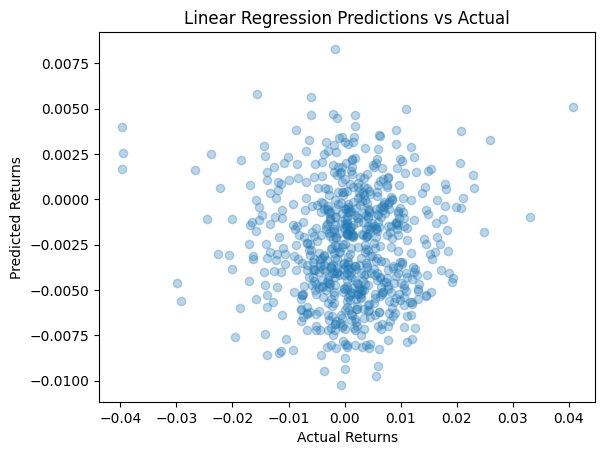

In [14]:

plt.scatter(y_val, y_pred, alpha=0.3)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Linear Regression Predictions vs Actual")
plt.show()

### Lasso regression

In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

In [4]:
df = pd.read_csv("train_enriched.csv")
dummy_features = [col for col in df.columns if col[0] == 'D']
standard_features = [col for col in df.columns if col[0] in ['E','I','M','P','S','V']]
features = dummy_features + standard_features
target = ['forward_returns']

In [ ]:
X = df[features]
y = df[target]
X_train = X.iloc[:5000]
y_train = y.iloc[:5000]
X_test = X.iloc[5000:]
y_test = y.iloc[5000:]

X_train_scaled = (X_train - X_train.mean()) / X_train.std()
X_test_scaled = (X_test - X_train.mean()) / X_train.std()

In [ ]:
lasso = Lasso(alpha = 0.0001)
lasso.fit(X_train_scaled,y_train)

In [ ]:
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

In [ ]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Lasso train data Mean Squared Error: {mse_train}")
print(f"Lasso test data Mean Squared Error: {mse_test}")

In [ ]:
R2 = r2_score(y_test, y_test_pred)
print(f"Lasso test data R2 Score: {R2}")

In [ ]:
rho, pval = spearmanr(y_test, lasso.predict(X_test))
print(f"Lasso Spearman's rho: {rho}, p-value: {pval}")

In [ ]:
accuracy = np.mean(np.sign(lasso.predict(X_test)) == np.sign(y_test.squeeze()))
print("Directional accuracy:", accuracy)

In [ ]:
baseline = np.array([np.mean(y_test)]*len(y_test))
accuracy = np.mean(np.sign(baseline) == np.sign(y_test.squeeze()))
mse = mean_squared_error(y_test, baseline)
R2 = r2_score(y_test, baseline)
print("Baseline directional accuracy:", accuracy)
print(f"Baseline R2 Score: {R2}")
print(f"Baseline Mean Squared Error: {mse}")

In [16]:
# try naive feature selection using top correlated features
corr = df[features + target].corr(method='spearman')

In [21]:
top_corr_features = corr['forward_returns'].abs().sort_values(ascending=False).index[1:21].tolist()
top_corr_features

['M4_lag1',
 'M4_roll_mean_5',
 'M4',
 'P5_lag1',
 'V13',
 'S5_roll_mean_30',
 'P5_roll_mean_5',
 'P5',
 'S5_roll_mean_5',
 'S5_lag1',
 'S2',
 'V13_roll_mean_5',
 'V13_lag1',
 'S5_roll_mean_15',
 'S5',
 'P8_roll_std_15',
 'P8_roll_std_5',
 'E10_roll_std_15',
 'E19',
 'P10_roll_std_5']

In [22]:
X = df[top_corr_features]
y = df[target]
X_train = X.iloc[:5000]
y_train = y.iloc[:5000]
X_test = X.iloc[5000:]
y_test = y.iloc[5000:]

X_train_scaled = (X_train - X_train.mean()) / X_train.std()
X_test_scaled = (X_test - X_train.mean()) / X_train.std()

In [26]:
lasso = Lasso(alpha = 0.001)
lasso.fit(X_train_scaled,y_train)

,alpha,0.001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [27]:
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

In [28]:
R2 = r2_score(y_test, y_test_pred)
print(f"Lasso test data R2 Score: {R2}")

Lasso test data R2 Score: -0.0005301420276331292


In [ ]:
# try kernel PCA
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(
    n_components=10, 
    kernel='rbf')


### Tree-based models

#### Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
train_df = pd.read_csv('train_stationalized.csv')
features = [col for col in train_df.columns if col[0] in ['D','E','I','M','P','S','V']]
target = 'forward_returns'

X = train_df[features]
y = train_df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


In [7]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    max_features=0.7
)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.7
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Random Forest RMSE: {mse:.6f}")

Random Forest RMSE: 0.000083


In [13]:
accuracy = np.mean(np.sign(y_pred) == np.sign(y_val))
print("Directional accuracy:", accuracy)

Directional accuracy: 0.5252976190476191


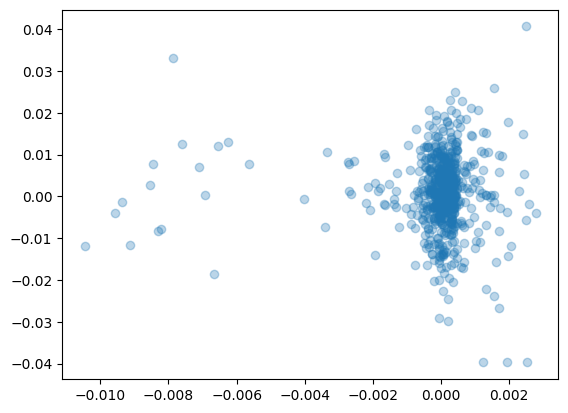

In [11]:
plt.plot(y_pred, y_val, 'o', alpha=0.3)

In [16]:
rho, pval = spearmanr(y_val, y_pred)
print(f"Spearman correlation (ρ): {rho:.4f}")
print(f"P-value: {pval:.4e}")

Spearman correlation (ρ): 0.0095
P-value: 8.0505e-01


#### LightGBM

In [30]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("train_enriched.csv")
dummy_features = [col for col in df.columns if col[0] == 'D']
standard_features = [col for col in df.columns if col[0] in ['E','I','M','P','S','V']]
features = dummy_features + standard_features
target = ['forward_returns']

In [4]:
X = df[features]
y = df[target]

##### Simple model trial 

In [7]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 64
}

oof_preds = np.zeros(len(X))
models = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_ds = lgb.Dataset(X_train, y_train)
    val_ds = lgb.Dataset(X_val, y_val)

    model = lgb.train(
        params,
        train_ds,
        valid_sets=[train_ds, val_ds],
        valid_names=["train", "valid"],
        num_boost_round=5000
    )

    models.append(model)

    oof_preds[val_idx] = model.predict(X_val)

Fold 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183546
[LightGBM] [Info] Number of data points in the train set: 1158, number of used features: 746
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [26]:
score = spearmanr(oof_preds, y)[0]
p_value = spearmanr(oof_preds, y)[1]
print(f"P-value: {p_value}")
print("OOF Spearman:", score)

P-value: 0.0406791040079545
OOF Spearman: 0.024564703010218958


In [28]:
accuracy = np.mean(np.sign(oof_preds) == np.sign(y.squeeze()))
print("LightGBM directional accuracy:", accuracy)

LightGBM directional accuracy: 0.4067406020452254


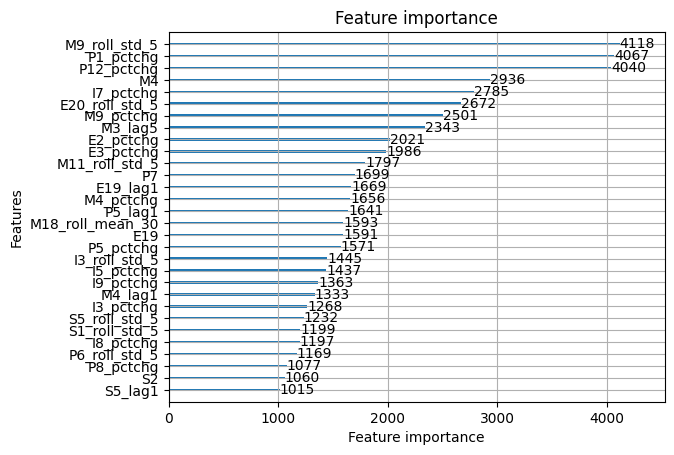

In [31]:
lgb.plot_importance(models[0], max_num_features=30)
plt.show()

##### Simple model trial with feature selections based on corr

In [38]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 64
}

oof_preds = np.zeros(len(X))
models = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model_fs = lgb.train(params, lgb.Dataset(X_train, y_train))
    fi = model_fs.feature_importance(importance_type="gain")
    names = model_fs.feature_name()

    top_features = [names[i] for i in np.argsort(fi)[::-1][:70]]


    train_ds = lgb.Dataset(X_train[top_features], y_train)
    val_ds = lgb.Dataset(X_val[top_features], y_val)

    model = lgb.train(
        params,
        train_ds,
        valid_sets=[train_ds, val_ds],
        valid_names=["train", "valid"],
        num_boost_round=5000
    )

    models.append(model)

    oof_preds[val_idx] = model.predict(X_val[top_features])

Fold 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183546
[LightGBM] [Info] Number of data points in the train set: 1158, number of used features: 746
[LightGBM] [Info] Start training from score 0.000018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [39]:
score = spearmanr(oof_preds, y)[0]
p_value = spearmanr(oof_preds, y)[1]
print("OOF Spearman:", score)
print(f"P-value: {p_value}")

OOF Spearman: -0.0030966451698829964
P-value: 0.7964215050051356


##### Hyperparameters tuning with Optuna

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import optuna

/Users/minqi/Documents/Kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# def lgb_spearman(preds, dataset):
#     y = dataset.get_label()
#     return 'spearman', spearmanr(preds, y)[0], True

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [5]:
def objective(trial):
    
    # --- Hyperparameter search space ---
    params = {
        "objective": "regression",
        "metric": "None",  # custom
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "verbosity": -1
    }

    oof_preds = np.zeros(len(X))
    scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_ds = lgb.Dataset(X_train, y_train)
        val_ds = lgb.Dataset(X_val, y_val)

        model = lgb.train(
            params,
            train_ds,
            valid_sets=[val_ds],
            valid_names=["valid"],
            num_boost_round=3000
        )

        preds = model.predict(X_val)
        oof_preds[val_idx] = preds
        fold_score = spearmanr(preds, y_val)[0]
        scores.append(fold_score)

    return np.mean(scores)


In [8]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-11-22 19:47:56,046] A new study created in memory with name: no-name-1365af8b-15c1-4a5b-9fc1-8b484663db94
/var/folders/bt/4b3dr6ws7f92mwnjqkr28dg80000gn/T/ipykernel_53197/2481945158.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  fold_score = spearmanr(preds, y_val)[0]
/var/folders/bt/4b3dr6ws7f92mwnjqkr28dg80000gn/T/ipykernel_53197/2481945158.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  fold_score = spearmanr(preds, y_val)[0]
/var/folders/bt/4b3dr6ws7f92mwnjqkr28dg80000gn/T/ipykernel_53197/2481945158.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  fold_score = spearmanr(preds, y_val)[0]
/var/folders/bt/4b3dr6ws7f92mwnjqkr28dg80000gn/T/ipykernel_53197/2481945158.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  fold_score = spearmanr(preds, y_val)[0]
/var/folde

In [9]:
best_params = study.best_params
print("Best params:", best_params)
print("Best score:", study.best_value)

Best params: {'learning_rate': 0.02516322710697048, 'num_leaves': 75, 'max_depth': 10, 'feature_fraction': 0.663295354468474, 'bagging_fraction': 0.6879390973331929, 'bagging_freq': 5, 'lambda_l1': 0.23652040357960147, 'lambda_l2': 2.344553589281089, 'min_data_in_leaf': 95}
Best score: 0.03208599325129265


In [11]:
final_params = {
    **best_params,
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
}

train_ds = lgb.Dataset(X[:5000], label=y[:5000])
final_model = lgb.train(final_params, train_ds, num_boost_round=study.best_trial.user_attrs.get("best_iteration", 2000))

In [13]:
y_pred = final_model.predict(X[5000:])
y_pred

array([ 0.00099825,  0.00229862,  0.00136381, ..., -0.002128  ,
       -0.00178759, -0.00383024], shape=(1943,))

In [ ]:
spearmanr(y_pred, y[5000:])

SignificanceResult(statistic=np.float64(0.020925842023202267), pvalue=np.float64(0.3565768498724844))

#### XGBoost